In [1]:
import np

from plot_utils import plot_loss, plot_histogram_balance_of_dataset, plot_confusion_matrix, plot_multiclass_roc_auc
from model import Model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from plot_utils import plot_multiclass_calibration_curve

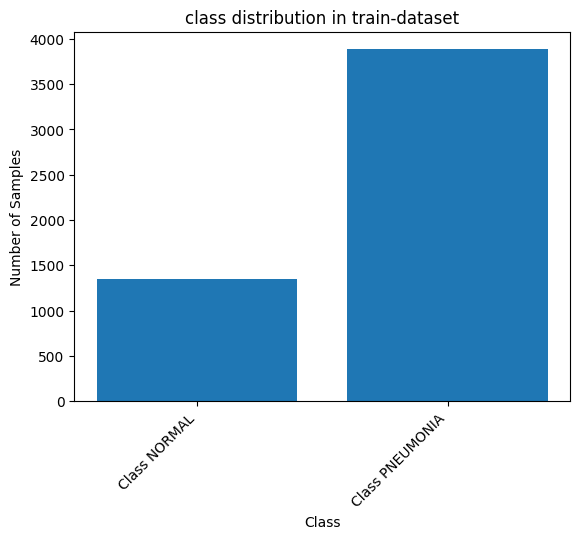

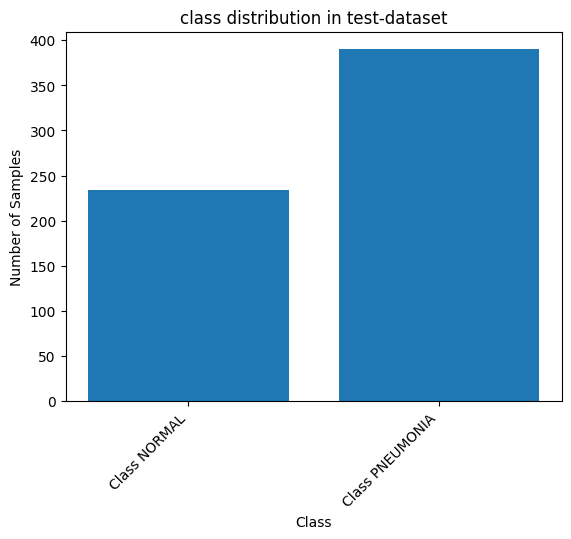

In [2]:
train_val_split_ratio = 0.9
batch_size = 16
learning_rate = 1e-7
patience_early_stopping = 10
patience_reduce_learning_rate = 4
weight_decay = 1e-4
momentum = 0.9
epochs = 500
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"

model = Model(learning_rate=learning_rate, batch_size=batch_size, patience_early_stopping=patience_early_stopping,
              patience_reduce_learning_rate=patience_reduce_learning_rate, train_dir=train_dir,
              weight_decay=weight_decay, momentum=momentum, test_dir=test_dir,
              train_val_split_ratio=train_val_split_ratio)

plot_histogram_balance_of_dataset(train_dir, "class distribution in train-dataset")
plot_histogram_balance_of_dataset(test_dir, "class distribution in test-dataset")

In [ ]:
train_losses, val_losses = model.train_model(epochs)

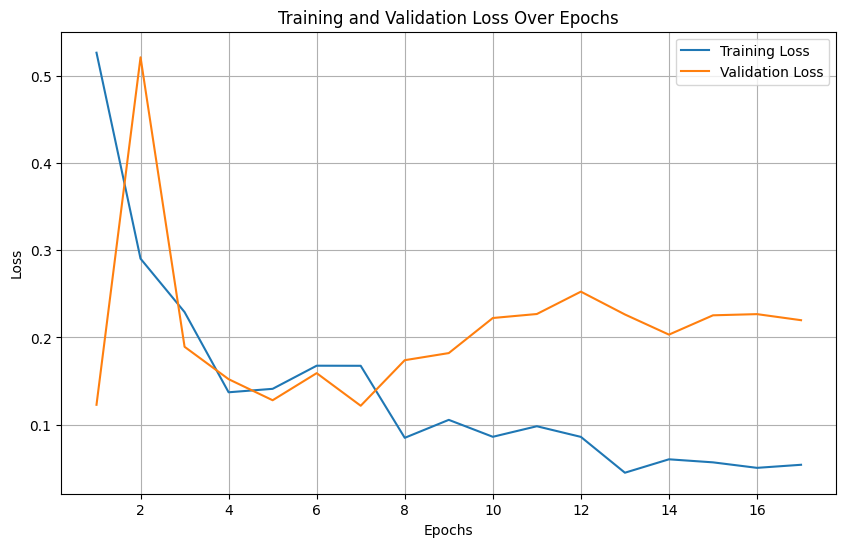

In [49]:
plot_loss(train_losses, val_losses)

In [50]:
true_labels, predicted_labels, confidence_values, confidence_all_classes, loss = model.evaluate()

In [51]:
print("F1-score: " + str(f1_score(true_labels, predicted_labels, average='macro')))
print("Recall: " + str(recall_score(true_labels, predicted_labels, average='macro')))
print("Precision: " + str(precision_score(true_labels, predicted_labels, average='macro')))
print("Accuracy: " + str(accuracy_score(true_labels, predicted_labels)))

F1-score: 0.8475109670036238
Recall: 0.8273504273504273
Precision: 0.90574238061607
Accuracy: 0.8685897435897436


[[8.8945842e-01 1.1054155e-01]
 [8.1031895e-01 1.8968108e-01]
 [6.0923296e-01 3.9076701e-01]
 ...
 [9.5558572e-19 1.0000000e+00]
 [2.3184913e-13 1.0000000e+00]
 [3.1762665e-05 9.9996829e-01]]


IndexError: index 1 is out of bounds for axis 1 with size 1

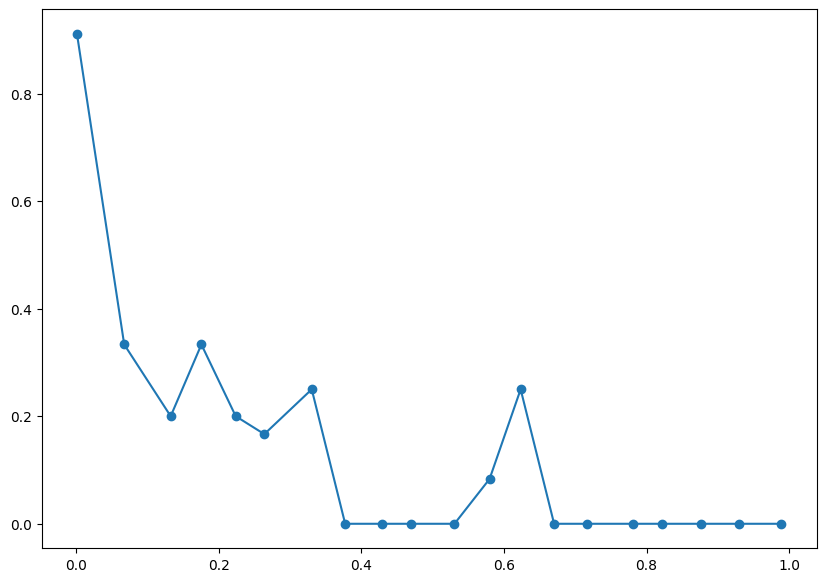

In [57]:
print(confidence_all_classes)
plot_multiclass_calibration_curve(y_true=true_labels, y_pred_proba=np.array(confidence_all_classes))

IndexError: index 1 is out of bounds for axis 1 with size 1

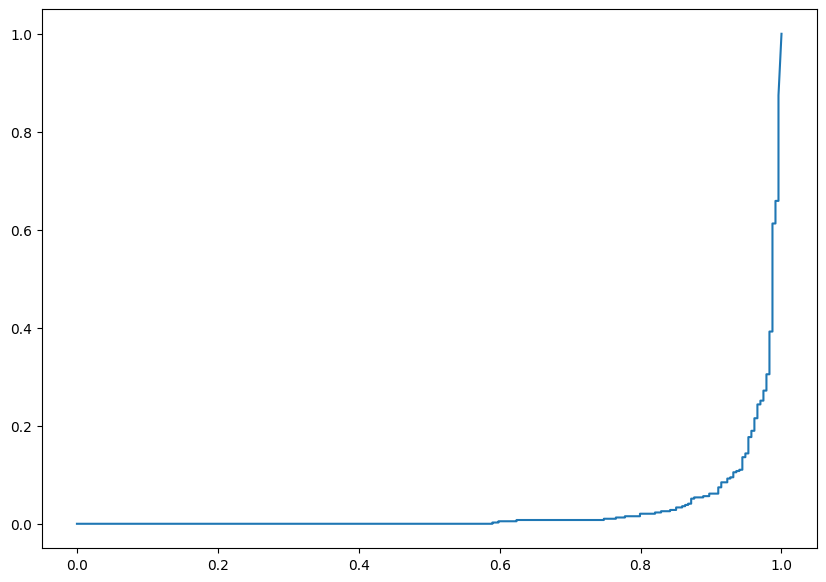

In [54]:
plot_multiclass_roc_auc(y_true=true_labels, y_pred_proba=np.array(confidence_all_classes))

In [39]:
import torch

torch.save(model.model.state_dict(), "model2.pth")

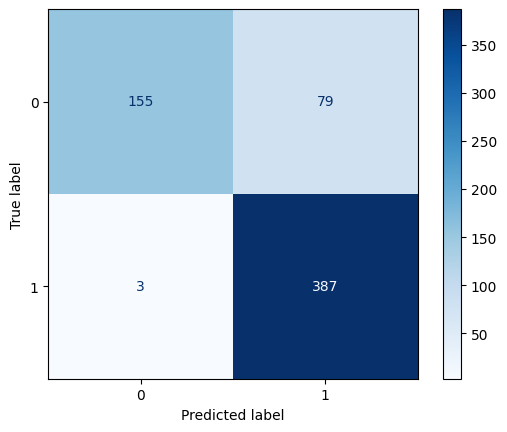

In [56]:
plot_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels)

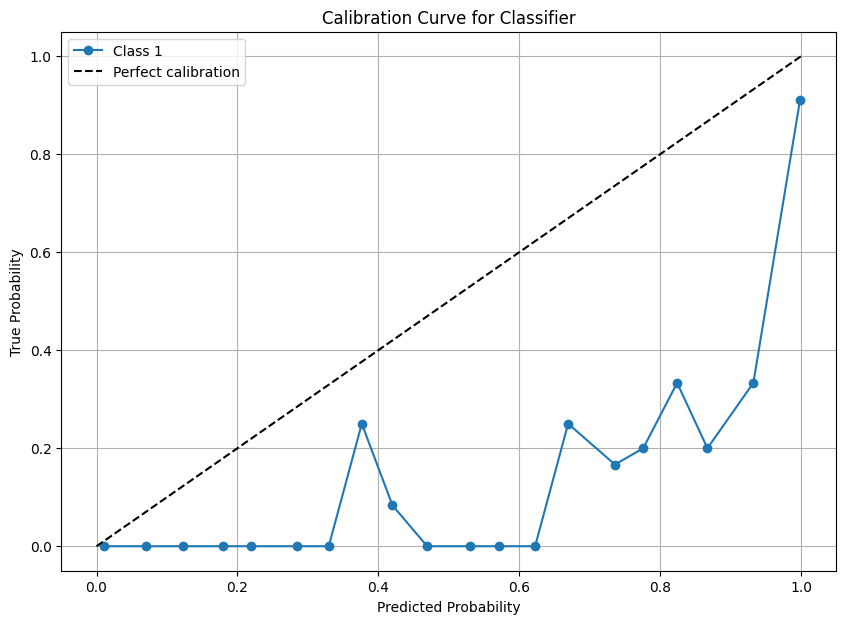

In [85]:
model.optimize_platt_scaling()
true_labels, predicted_labels, confidence_values, confidence_all_classes, loss = model.evaluate()
plot_multiclass_calibration_curve(true_labels, confidence_all_classes)

AttributeError: 'Model' object has no attribute 'optimize_platt_scaling'